## Setting the environment

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2 Physical GPUs, 2 Logical GPUs


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import missingno as msno
import seaborn as sns
from numpy import asarray
from numpy import zeros
import requests
import zipfile
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [3]:
data    = pd.read_csv('/kaggle/input/glassdoor-job-reviews/glassdoor_reviews.csv', sep=',', encoding='latin-1')
print("All columns : ");
print(data.columns);
Notkeep = [d for d in data.columns if d not in ['overall_rating','headline','pros','cons','firm']]
print("\nRemoved columns : ");
print(Notkeep);
data    = data.drop(columns=Notkeep)
print("\nSelected columns : ");
print(data.columns);

All columns : 
Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

Removed columns : 
['date_review', 'job_title', 'current', 'location', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv', 'outlook']

Selected columns : 
Index(['firm', 'overall_rating', 'headline', 'pros', 'cons'], dtype='object')


In [4]:
data['review'] = data['headline']+'. '+data['pros']+'. '+data['cons'];
data.drop(columns=['headline','pros','cons'], inplace=True)
data

,firm,overall_rating,review
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ..."
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu..."
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t..."
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N..."
...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...
838563,the-LEGO-Group,4,not interested in growing their people. loved ...
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l..."


In [5]:
def sent(rating):
    if rating['overall_rating'] >= 3:
        value = 'positive' 
    else:
        value = 'negative'
    return value

data['sentiment'] = data.apply(sent, axis=1)
data.drop(columns=['overall_rating'], inplace=True)
data

,firm,review,sentiment
0,AFH-Wealth-Management,"Young colleagues, poor micro management. Very ...",negative
1,AFH-Wealth-Management,"Excellent staff, poor salary. Friendly, helpfu...",negative
2,AFH-Wealth-Management,"Low salary, bad micromanagement. Easy to get t...",negative
3,AFH-Wealth-Management,Over promised under delivered. Nice staff to w...,positive
4,AFH-Wealth-Management,"client reporting admin. Easy to get the job, N...",negative
...,...,...,...
838561,the-LEGO-Group,Just an awesome company to work for!!!. Great ...,positive
838562,the-LEGO-Group,working at lego. staff discount is really nice...,positive
838563,the-LEGO-Group,not interested in growing their people. loved ...,positive
838564,the-LEGO-Group,"Great Place to Work. Good wages, good hours, l...",positive


In [6]:
data.shape

(838566, 3)

In [7]:
data.head(5)

,firm,review,sentiment
0,AFH-Wealth-Management,"Young colleagues, poor micro management. Very ...",negative
1,AFH-Wealth-Management,"Excellent staff, poor salary. Friendly, helpfu...",negative
2,AFH-Wealth-Management,"Low salary, bad micromanagement. Easy to get t...",negative
3,AFH-Wealth-Management,Over promised under delivered. Nice staff to w...,positive
4,AFH-Wealth-Management,"client reporting admin. Easy to get the job, N...",negative


In [8]:
data.isnull().values.any()

True

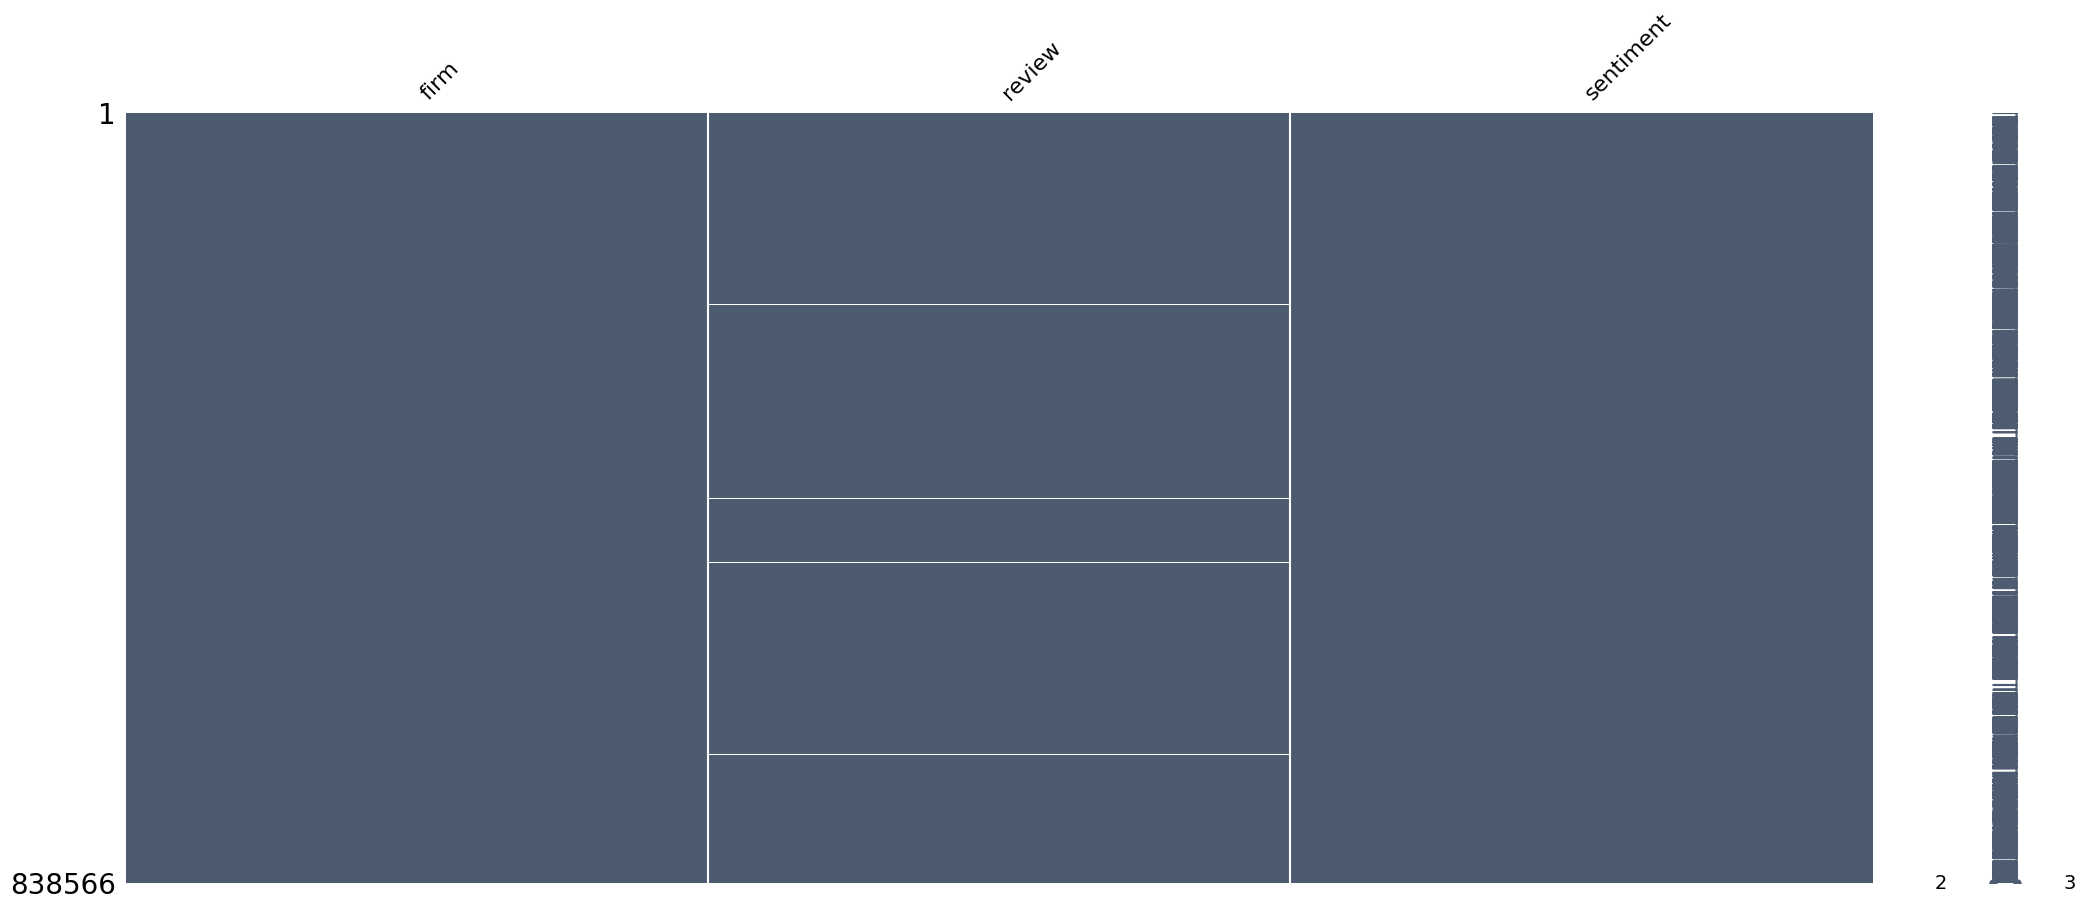

In [9]:
msno.matrix(data,color=(0.3,0.36,0.44));

In [10]:
data.isna().sum()

firm            0
review       2605
sentiment       0
dtype: int64

In [11]:
data.dropna(subset=['review'], inplace=True)

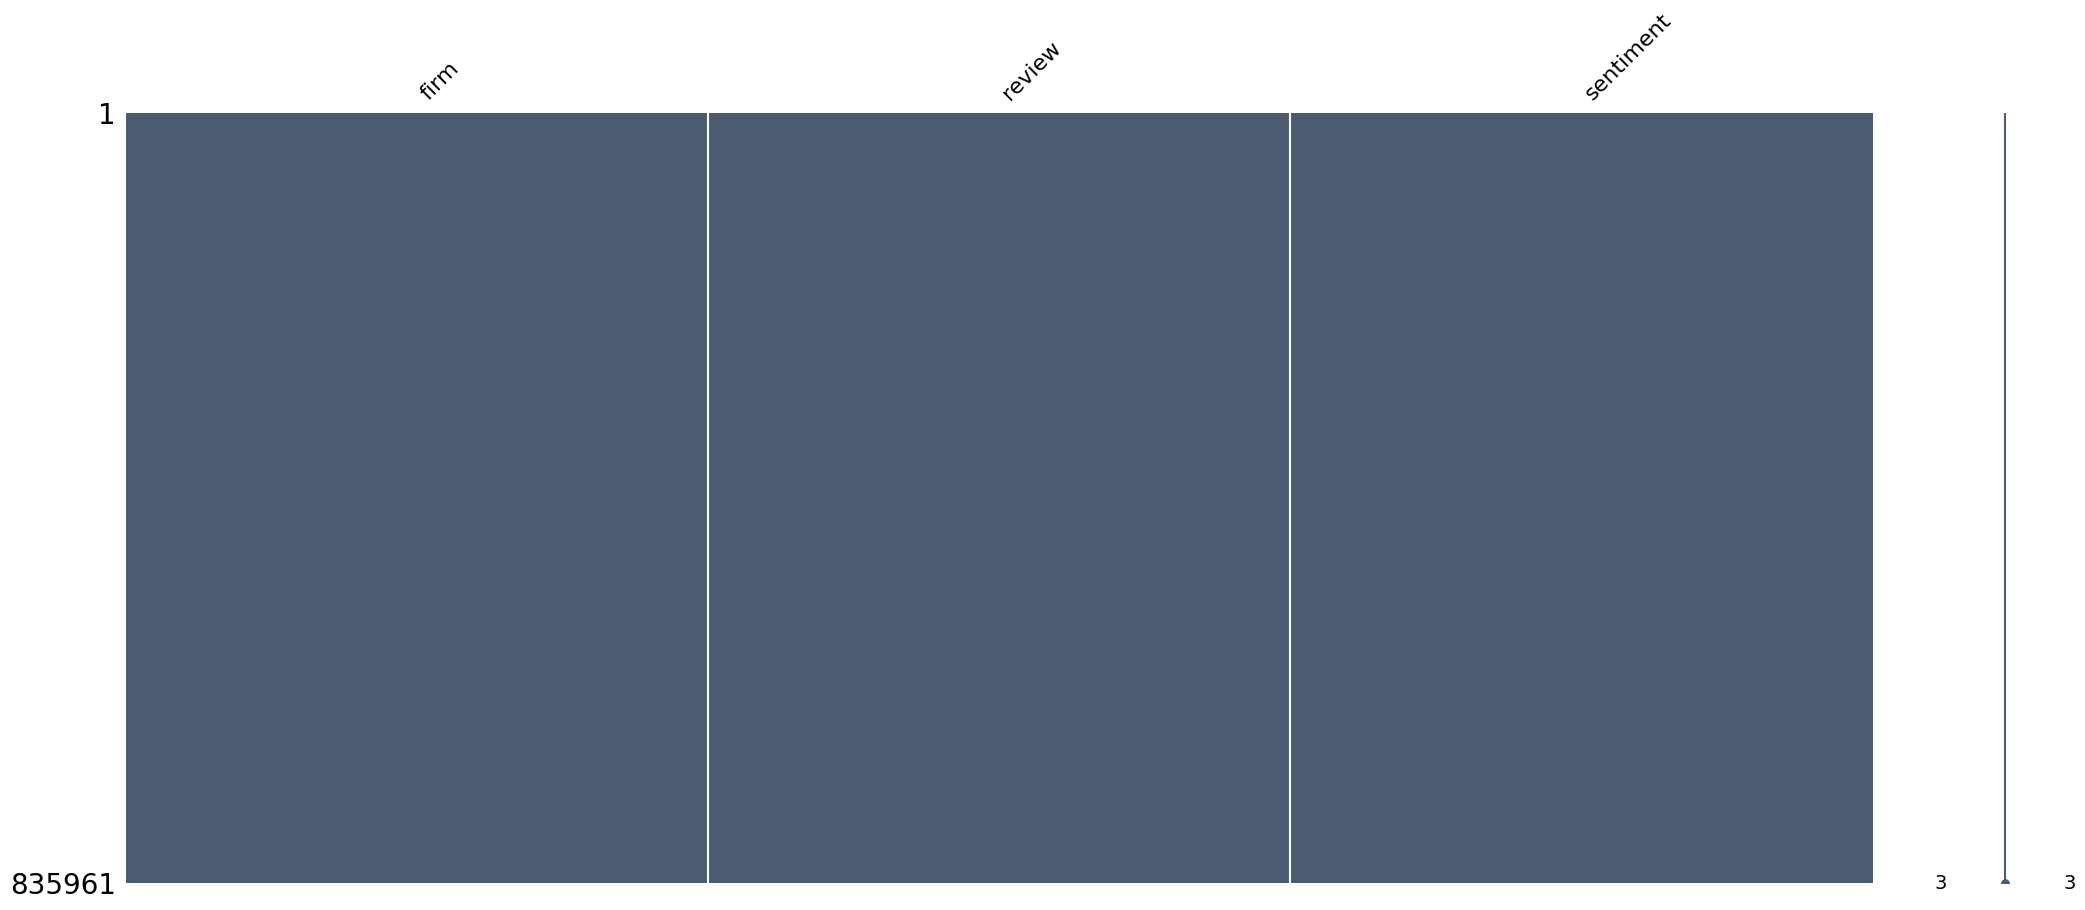

In [12]:
msno.matrix(data,color=(0.3,0.36,0.44));

In [13]:
data.isna().sum()

firm         0
review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

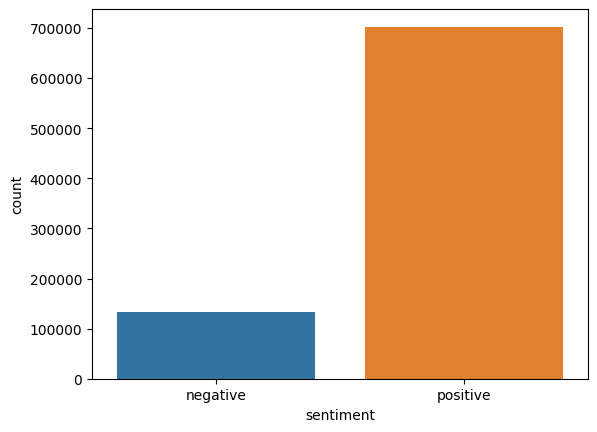

In [14]:
sns.countplot(x='sentiment', data=data)

In [15]:
sentiment_counts = data['sentiment'].value_counts()
sentiment_counts

sentiment
positive    702529
negative    133432
Name: count, dtype: int64

In [16]:
negative_rows = data[data['sentiment'] == 'negative']
positive_rows = data[data['sentiment'] == 'positive']

random_negative_rows = negative_rows.sample(n=3432, random_state=42)
random_positive_rows = positive_rows.sample(n=572529, random_state=42)

data.drop(random_negative_rows.index, inplace=True)
data.drop(random_positive_rows.index, inplace=True)

In [17]:
sentiment_counts = data['sentiment'].value_counts()
sentiment_counts

sentiment
negative    130000
positive    130000
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

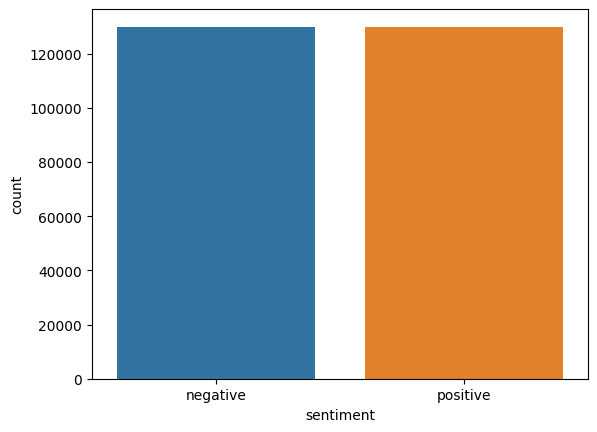

In [18]:
sns.countplot(x='sentiment', data=data)

## Data Preprocessing

In [19]:
data["review"][2]

'Low salary, bad micromanagement. Easy to get the job even without experience in finance. Very low salary, poor working conditions, very little training provided but high expectations. Micro management are young, inexperienced and superficial girls who are not able to provide guidance and support for their teams.'

In [20]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [23]:
data['review'] = data['review'].apply(preprocess_text)
data

,firm,review,sentiment
0,AFH-Wealth-Management,young colleagues poor micro management friendl...,negative
1,AFH-Wealth-Management,excellent staff poor salary friendly helpful h...,negative
2,AFH-Wealth-Management,low salary bad micromanagement easy get job ev...,negative
4,AFH-Wealth-Management,client reporting admin easy get job nice colle...,negative
6,AFH-Wealth-Management,horrible management good investment management...,negative
...,...,...,...
838557,the-LEGO-Group,ok work discount lego sets management bad,negative
838558,the-LEGO-Group,great brand family owned great brand danish cu...,positive
838559,the-LEGO-Group,friendly staff members lego staff friendly get...,negative
838560,the-LEGO-Group,awesome place work company clear purpose one t...,positive


In [24]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.tokenize import word_tokenize

tokenized_review = data['review'].apply(word_tokenize)

phrases_model_review = Phrases(tokenized_review, min_count=1, threshold=100)

phrases_review = Phraser(phrases_model_review)

collocation_detected_review = list(phrases_review[tokenized_review])

collocation_detected_review = [' '.join(tokens) for tokens in collocation_detected_review]

data['review'] = collocation_detected_review

data

,firm,review,sentiment
0,AFH-Wealth-Management,young colleagues poor micro management friendl...,negative
1,AFH-Wealth-Management,excellent staff poor salary friendly helpful h...,negative
2,AFH-Wealth-Management,low salary bad micromanagement easy get job ev...,negative
4,AFH-Wealth-Management,client reporting admin easy get job nice colle...,negative
6,AFH-Wealth-Management,horrible management good investment management...,negative
...,...,...,...
838557,the-LEGO-Group,ok work discount lego_sets management bad,negative
838558,the-LEGO-Group,great brand family owned great brand danish cu...,positive
838559,the-LEGO-Group,friendly staff members lego staff friendly get...,negative
838560,the-LEGO-Group,awesome place work company clear purpose one t...,positive


In [25]:
X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(sen)

In [26]:
X[2]

'low salary bad micromanagement easy get job even without experience finance low salary poor working conditions little training provided high expectations micro management young inexperienced superficial girls able provide guidance support teams'

In [27]:
y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing embedding layer

In [29]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [30]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

59794

In [31]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [32]:
embeddings_dictionary = dict()

glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'

response = requests.get(glove_url, stream=True)

with open('glove.6B.zip', 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [33]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
embedding_matrix.shape

(59794, 100)

# Model Training with:

## Simple Neural Network

In [35]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [36]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5979400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 5,989,401
Trainable params: 10,001
Non-trainable params: 5,979,400
_________________________________________________________________
None


In [37]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Epoch 1/20
1138/1138 [==============================] - 9s 4ms/step - loss: 0.4839 - acc: 0.7667 - val_loss: 0.4677 - val_acc: 0.7747
Epoch 2/20
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4511 - acc: 0.7869 - val_loss: 0.4732 - val_acc: 0.7747
Epoch 3/20
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4442 - acc: 0.7903 - val_loss: 0.4720 - val_acc: 0.7780
Epoch 4/20
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4409 - acc: 0.7917 - val_loss: 0.4766 - val_acc: 0.7785
Epoch 5/20
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4378 - acc: 0.7937 - val_loss: 0.4774 - val_acc: 0.7768
Epoch 6/20
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4359 - acc: 0.7944 - val_loss: 0.4823 - val_acc: 0.7769
Epoch 7/20
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4344 - acc: 0.7953 - val_loss: 0.4867 - val_acc: 0.7730
Epoch 8/20
1138/1138 [==============================] - 4s 4ms

In [38]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

1625/1625 [==============================] - 4s 2ms/step - loss: 0.5041 - acc: 0.7751


In [39]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5041202902793884
Test Accuracy: 0.7751346230506897


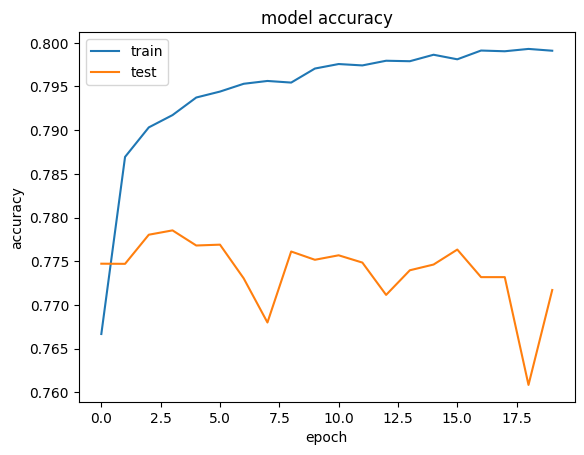

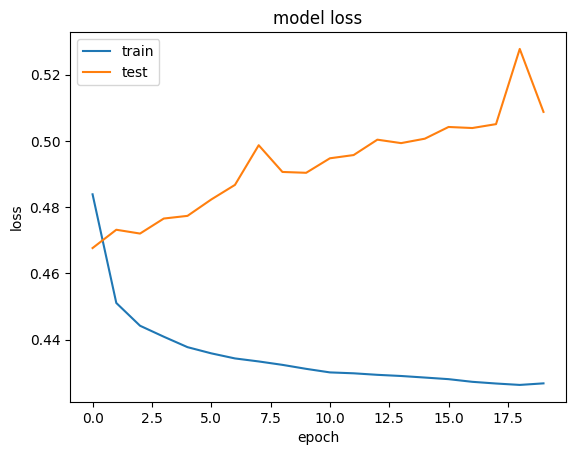

In [40]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [41]:
from keras.layers import Conv1D

In [42]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [43]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5979400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,043,657
Trainable params: 64,257
Non-trainable params: 5,979,400
_________________________________________________________________
None


In [44]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Epoch 1/20
1138/1138 [==============================] - 12s 5ms/step - loss: 0.4556 - acc: 0.7844 - val_loss: 0.4313 - val_acc: 0.8008
Epoch 2/20
1138/1138 [==============================] - 5s 5ms/step - loss: 0.4069 - acc: 0.8134 - val_loss: 0.4300 - val_acc: 0.8006
Epoch 3/20
1138/1138 [==============================] - 5s 5ms/step - loss: 0.3783 - acc: 0.8306 - val_loss: 0.4259 - val_acc: 0.8048
Epoch 4/20
1138/1138 [==============================] - 5s 5ms/step - loss: 0.3540 - acc: 0.8441 - val_loss: 0.4349 - val_acc: 0.8007
Epoch 5/20
1138/1138 [==============================] - 5s 5ms/step - loss: 0.3315 - acc: 0.8551 - val_loss: 0.4524 - val_acc: 0.7943
Epoch 6/20
1138/1138 [==============================] - 6s 5ms/step - loss: 0.3099 - acc: 0.8670 - val_loss: 0.4545 - val_acc: 0.7967
Epoch 7/20
1138/1138 [==============================] - 5s 5ms/step - loss: 0.2934 - acc: 0.8759 - val_loss: 0.4958 - val_acc: 0.7818
Epoch 8/20
1138/1138 [==============================] - 5s 5m

In [45]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

1625/1625 [==============================] - 4s 2ms/step - loss: 0.8454 - acc: 0.7523


In [46]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8454064726829529
Test Accuracy: 0.7522692084312439


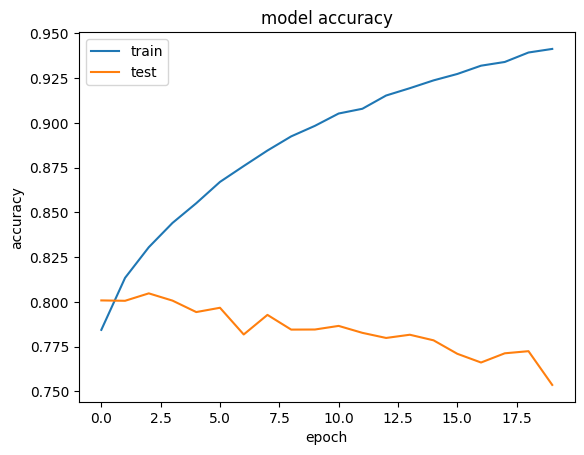

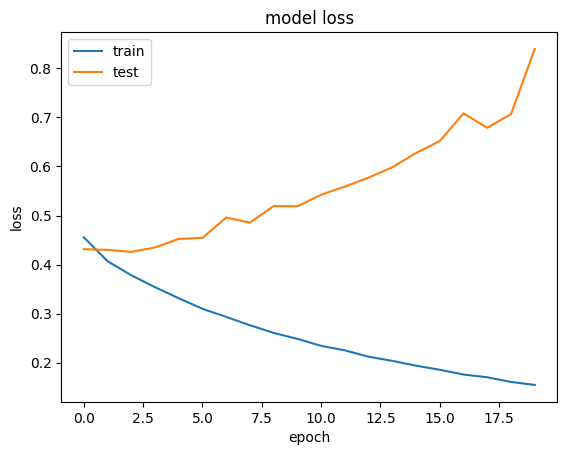

In [47]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [48]:
from keras.layers import LSTM

In [49]:
from tensorflow.keras.layers import Dropout

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(20))
lstm_model.add(Dropout(0.1))

lstm_model.add(Dense(1, activation='sigmoid'))

In [50]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(clipvalue=4.0)
lstm_model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          5979400   
                                                                 
 lstm (LSTM)                 (None, 20)                9680      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,989,101
Trainable params: 9,701
Non-trainable params: 5,979,400
_________________________________________________________________
None


In [51]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Epoch 1/20
1138/1138 [==============================] - 13s 8ms/step - loss: 0.5122 - acc: 0.7535 - val_loss: 0.4493 - val_acc: 0.7913
Epoch 2/20
1138/1138 [==============================] - 9s 8ms/step - loss: 0.4400 - acc: 0.7967 - val_loss: 0.4323 - val_acc: 0.8006
Epoch 3/20
1138/1138 [==============================] - 9s 8ms/step - loss: 0.4258 - acc: 0.8046 - val_loss: 0.4258 - val_acc: 0.8034
Epoch 4/20
1138/1138 [==============================] - 9s 8ms/step - loss: 0.4179 - acc: 0.8089 - val_loss: 0.4349 - val_acc: 0.8084
Epoch 5/20
1138/1138 [==============================] - 9s 8ms/step - loss: 0.4104 - acc: 0.8124 - val_loss: 0.4309 - val_acc: 0.8068
Epoch 6/20
1138/1138 [==============================] - 9s 8ms/step - loss: 0.4070 - acc: 0.8141 - val_loss: 0.4108 - val_acc: 0.8113
Epoch 7/20
1138/1138 [==============================] - 9s 8ms/step - loss: 0.4026 - acc: 0.8165 - val_loss: 0.4111 - val_acc: 0.8134
Epoch 8/20
1138/1138 [==============================] - 9s 8m

In [52]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

1625/1625 [==============================] - 6s 4ms/step - loss: 0.4132 - acc: 0.8107


In [53]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4131513237953186
Test Accuracy: 0.8106538653373718


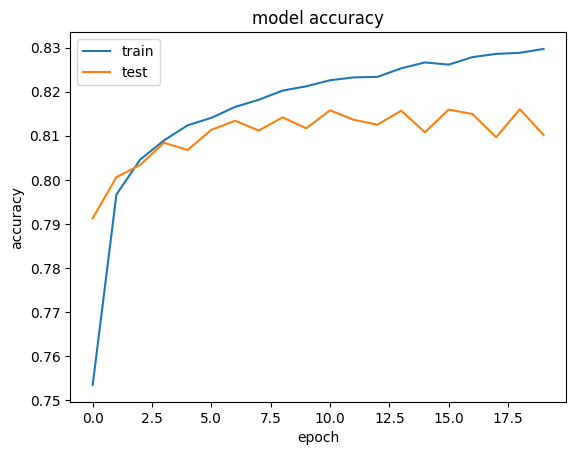

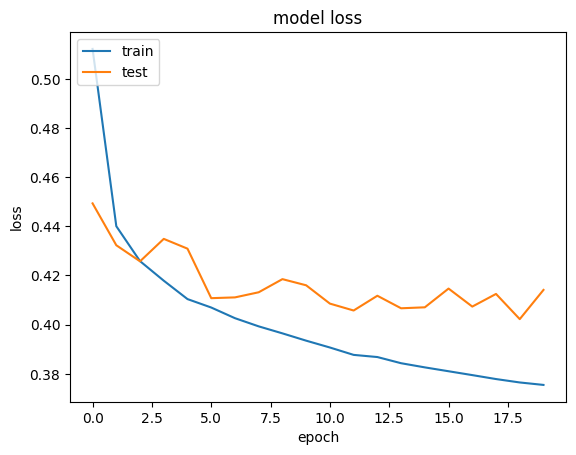

In [54]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [55]:
lstm_model.save("/kaggle/working/sentiment_LSTM_model.keras")

# Making Predictions

In [56]:
df    = pd.read_csv('/kaggle/input/glassdoor-job-reviews/glassdoor_reviews.csv', sep=',', encoding='latin-1')
print("All columns : ");
print(df.columns);
Notkeep = [d for d in df.columns if d not in ['overall_rating','headline','pros','cons','firm']]
print("\nRemoved columns : ");
print(Notkeep);
df    = df.drop(columns=Notkeep)
print("\nSelected columns : ");
print(df.columns);

All columns : 
Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

Removed columns : 
['date_review', 'job_title', 'current', 'location', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv', 'outlook']

Selected columns : 
Index(['firm', 'overall_rating', 'headline', 'pros', 'cons'], dtype='object')


In [57]:
df['review'] = df['headline']+'. '+df['pros']+'. '+df['cons'];
df.drop(columns=['headline','pros','cons'], inplace=True)
df

,firm,overall_rating,review
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ..."
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu..."
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t..."
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N..."
...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...
838563,the-LEGO-Group,4,not interested in growing their people. loved ...
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l..."


In [58]:
df.isna().sum()

firm                 0
overall_rating       0
review            2605
dtype: int64

In [59]:
df.dropna(subset=['review'], inplace=True)
df.isna().sum()

firm              0
overall_rating    0
review            0
dtype: int64

In [60]:
df

,firm,overall_rating,review
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ..."
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu..."
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t..."
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N..."
...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...
838563,the-LEGO-Group,4,not interested in growing their people. loved ...
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l..."


In [61]:
unseen_reviews = df['review']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [62]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [63]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

26124/26124 [==============================] - 72s 3ms/step


array([[0.15012121],
       [0.49151212],
       [0.06127306],
       ...,
       [0.47201824],
       [0.9638182 ],
       [0.9839792 ]], dtype=float32)

In [64]:
df['Predicted_Sentiments'] = np.round(unseen_sentiments*10,1)

df

,firm,overall_rating,review,Predicted_Sentiments
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ...",1.5
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu...",4.9
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t...",0.6
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...,4.5
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N...",0.6
...,...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...,9.8
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...,6.5
838563,the-LEGO-Group,4,not interested in growing their people. loved ...,4.7
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l...",9.6


In [65]:
average_scores = df.groupby('firm')['Predicted_Sentiments'].mean().reset_index()
count_per_firm = df['firm'].value_counts().reset_index()

In [66]:
average_scores.to_csv('/kaggle/working/average_sentiment_scores.csv', index=False)
count_per_firm.to_csv('/kaggle/working/count_per_firm.csv', index=False)